# Standard Imports

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
from scipy.stats import gaussian_kde
from scipy.integrate import trapz
import matplotlib.pyplot as plt
from matplotlib import pylab
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


In [2]:
def find_pvals(merged_df, bf, sig):
    pvals_dict = {}
    pvals_dict, All_Sig = perform_ttest('All', pvals_dict, merged_df, bf, sig)
    pvals_dict, Hotspot_Sig = perform_ttest('Hotspot', pvals_dict, merged_df, bf, sig)
    pvals_dict, Non_Hotspot_Sig = perform_ttest('Non_Hotspot', pvals_dict, merged_df, bf, sig)
    
    if All_Sig == True or Hotspot_Sig == True or Non_Hotspot_Sig == True:
        sig = True
        
    return pvals_dict, sig

In [3]:
# Function to return a dictionary of mutation comparison pvalues from different data locations
def perform_ttest(comp_type, pvals_dict, merged_df, bf, sig):
    if comp_type == 'All':
        # Finding pvalues for the transcriptome
        t_mut = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Transcriptome']
        t_wt = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Transcriptome']
        t_tt = scipy.stats.ttest_ind(t_wt, t_mut)
        pvals_dict[comp_type + '_Txn_pval'] = t_tt[1]
        pvals_dict[comp_type + '_Txn_pval_-Log10'] = np.log10(t_tt[1])*-1
        # Finding pvalues for the proteome
        p_mut = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Proteome']
        p_wt = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Proteome']
        p_tt = scipy.stats.ttest_ind(p_wt, p_mut)
        pvals_dict[comp_type + '_Prot_pval'] = p_tt[1]
        pvals_dict[comp_type + '_Prot_pval_-Log10'] = np.log10(p_tt[1])*-1
        # Finding the mean difference for the transcriptome
        t_mut_mean = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Transcriptome'].mean()
        t_wt_mean = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
        t_dif = t_mut_mean - t_wt_mean
        pvals_dict[comp_type + '_Txn_Mean_Dif'] = t_dif
        # Finding the mean difference for the proteome
        p_mut_mean = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Proteome'].mean()
        p_wt_mean = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
        p_dif = p_mut_mean - p_wt_mean
        pvals_dict[comp_type + '_Prot_Mean_Dif'] = p_dif
        
    else:
        # Finding the pvalues for the transcriptome
        t_mut = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Transcriptome']
        t_wt = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Transcriptome']
        t_tt = scipy.stats.ttest_ind(t_wt, t_mut)
        pvals_dict[comp_type + '_Txn_pval'] = t_tt[1]
        pvals_dict[comp_type + '_Txn_pval_-Log10'] = np.log10(t_tt[1])*-1
        # Finding pvalues for the proteome
        p_mut = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Proteome']
        p_wt = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Proteome']
        p_tt = scipy.stats.ttest_ind(p_wt, p_mut)
        pvals_dict[comp_type + '_Prot_pval'] = p_tt[1]
        pvals_dict[comp_type + '_Prot_pval_-Log10'] = np.log10(p_tt[1])*-1
        # Finding the mean difference for the transcriptome
        t_mut_mean = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Transcriptome'].mean()
        t_wt_mean = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
        t_dif = t_mut_mean - t_wt_mean
        pvals_dict[comp_type + '_Txn_Mean_Dif'] = t_dif
        # Finding the mean difference for the proteome
        p_mut_mean = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Proteome'].mean()
        p_wt_mean = merged_df.loc[merged_df['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
        p_dif = p_mut_mean - p_wt_mean
        pvals_dict[comp_type + '_Prot_Mean_Dif'] = p_dif
        
    if t_tt[1] <= bf and p_tt[1] <= bf:
        pvals_dict[comp_type + '_Sig_In'] = 'Both'
        sig = True
    elif t_tt[1] <= bf and p_tt[1] > bf:
        pvals_dict[comp_type + '_Sig_In'] = 'Transcriptome'
        sig = True
    elif t_tt[1] > bf and p_tt[1] <= bf:
        pvals_dict[comp_type + '_Sig_In'] = 'Proteome'
        sig = True
    else:
        pvals_dict[comp_type + '_Sig_In'] = 'Neither'

    return pvals_dict, sig

In [4]:
def get_plot_comp(comp_type, data_type, df):
    px = df.loc[df[comp_type + '_Sig_In'] == 'Proteome', comp_type + '_Txn_' + data_type]
    py = df.loc[df[comp_type + '_Sig_In'] == 'Proteome', comp_type + '_Prot_' + data_type]
    p_unique = (px, py)

    tx = df.loc[df[comp_type + '_Sig_In'] == 'Transcriptome', comp_type + '_Txn_' + data_type]
    ty = df.loc[df[comp_type + '_Sig_In'] == 'Transcriptome', comp_type + '_Prot_' + data_type]
    t_unique = (tx, ty)

    sx = df.loc[df[comp_type + '_Sig_In'] == 'Both', comp_type + '_Txn_' + data_type]
    sy = df.loc[df[comp_type + '_Sig_In'] == 'Both', comp_type + '_Prot_' + data_type]
    shared = (sx, sy)
    
    data = (p_unique, t_unique, shared)

    return data
        

In [5]:
def get_plot_data(where_sig, data_type, df):
        
    px = df.loc[df['All_Sig_In'] == where_sig, 'All_Txn_' + data_type]
    py = df.loc[df['All_Sig_In'] == where_sig, 'All_Prot_' + data_type]
    p_unique = (px, py)

    tx = df.loc[df['Hotspot_Sig_In'] == where_sig, 'Hotspot_Txn_' + data_type]
    ty = df.loc[df['Hotspot_Sig_In'] == where_sig, 'Hotspot_Prot_' + data_type]
    t_unique = (tx, ty)

    sx = df.loc[df['Non_Hotspot_Sig_In'] == where_sig, 'Non_Hotspot_Txn_' + data_type]
    sy = df.loc[df['Non_Hotspot_Sig_In'] == where_sig, 'Non_Hotspot_Prot_' + data_type]
    shared = (sx, sy)
    
    data = (p_unique, t_unique, shared)

    return data

In [6]:
def get_plot_cross(comp_type, df):
    px = df.loc[df[comp_type + '_Sig_In'] == 'Proteome', comp_type + '_Txn_pval_-Log10']
    py = df.loc[df[comp_type + '_Sig_In'] == 'Proteome', comp_type + '_Prot_Mean_Dif']
    p_unique = (px, py)

    tx = df.loc[df[comp_type + '_Sig_In'] == 'Transcriptome', comp_type + '_Txn_pval_-Log10']
    ty = df.loc[df[comp_type + '_Sig_In'] == 'Transcriptome', comp_type + '_Prot_Mean_Dif']
    t_unique = (tx, ty)

    sx = df.loc[df[comp_type + '_Sig_In'] == 'Both', comp_type + '_Txn_pval_-Log10']
    sy = df.loc[df[comp_type + '_Sig_In'] == 'Both', comp_type + '_Prot_Mean_Dif']
    shared = (sx, sy)
    
    data = (p_unique, t_unique, shared)

    return data

In [7]:
# Seaborn Density Plot
def get_plot_density(comp_type, data_type, df):
    t_data = df.loc[df[comp_type + '_Sig_In'] == 'Transcriptome', comp_type + '_Txn_' + data_type]
    b_data = df.loc[df[comp_type + '_Sig_In'] == 'Both', comp_type + '_Txn_' + data_type]
    
    t_data = abs(t_data)
    b_data = abs(b_data)
    
    t_data = t_data.sort_values()
    b_data = b_data.sort_values()
    
    bw_t = 1.06 * t_data.std() * t_data.size ** (-1 / 5.)
    bw_b = 1.06 * b_data.std() * b_data.size ** (-1 / 5.)
    
    ax = sns.kdeplot(t_data, shade = True, bw = bw_t, label = comp_type + '_Transcriptome_Only')
    ax = sns.kdeplot(b_data, shade = True, bw = bw_b, label = comp_type + '_Both')
    plt.legend()
    plt.title('Density of Significance within the Data')
    plt.ylabel('Frequency of Significance')
    plt.xlabel('Magnitude of Txn ' + data_type)
    
    #sns.distplot(t_data, kde=False, fit=scipy.stats.gamma)
    #sns.distplot(b_data, kde=False, fit=scipy.stats.gamma)
    

In [8]:
def get_plot_hexbin(comp_type, data_type, df):
    t_data = df.loc[df[comp_type + '_Sig_In'] == 'Transcriptome', comp_type + '_Txn_' + data_type]
    b_data = df.loc[df[comp_type + '_Sig_In'] == 'Both', comp_type + '_Txn_' + data_type]
    
    t_data = abs(t_data)
    b_data = abs(b_data)
    
    t_data = t_data.sort_values()
    b_data = b_data.sort_values()
    
    x = np.array(t_data.dropna())
    y = np.array(b_data.dropna())
    
    with sns.axes_style('white'):
        sns.jointplot(x, y, kind = 'hex', color = 'k')

In [9]:
def get_plot_dist(comp_type, data_type, df):
    t_data = df.loc[df[comp_type + '_Sig_In'] == 'Transcriptome', comp_type + '_Txn_' + data_type]
    b_data = df.loc[df[comp_type + '_Sig_In'] == 'Both', comp_type + '_Txn_' + data_type]
    
    t_data = abs(t_data)
    b_data = abs(b_data)
    
    t_data = t_data.sort_values()
    b_data = b_data.sort_values()
    
    bw_t = 1.06 * t_data.std() * t_data.size ** (-1 / 5.)
    bw_b = 1.06 * b_data.std() * b_data.size ** (-1 / 5.)
    
    ax = sns.distplot(t_data, kde = True, label = comp_type + '_Transcriptome_Only')
    ax = sns.distplot(b_data, kde = True, label = comp_type + '_Both')
    plt.legend()
    plt.title('Density of Significance within the Data')
    plt.ylabel('Frequency of Significance')
    plt.xlabel('Magnitude of Txn ' + data_type)

### Designating CPTAC Variables

In [10]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
transcriptomics = CPTAC.get_transcriptomics()

### Designating a List of TP53 Hotspot Mutations Found in a Previous Analysis

In [11]:
# A list of mutations present in the hotspot according to our Hotspot3D output
gene = 'TP53'
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W','p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

In [12]:
shared_protein_list = list()
for protein in proteomics.columns:
    if protein in transcriptomics.columns:
        shared_protein_list.append(protein)

In [13]:
pcutoff = 0.05/len(shared_protein_list)
print('Our bonferroni p-cutoff value is ' + str(pcutoff))

Our bonferroni p-cutoff value is 4.551247041689423e-06


In [14]:
all_data = pd.DataFrame({'Protein': shared_protein_list})
for protein in shared_protein_list:
    sig = False
    proteomics_df = CPTAC.compare_mutations(proteomics, protein, gene)
    proteomics_df.columns = ['Proteome', 'Mutation', 'Sample_Status']
    transcriptomics_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    transcriptomics_df.columns = ['Transcriptome', 'Mutation', 'Sample_Status']
    merged_data = proteomics_df.join(transcriptomics_df['Transcriptome'])
    merged_data.loc[merged_data['Sample_Status'] == 'Tumor', 'Mutation_Type'] = 'Non_Hotspot'
    merged_data.loc[hotspot_patients, 'Mutation_Type'] = 'Hotspot'
    merged_data.loc[merged_data['Mutation'] == 'Wildtype_Tumor', 'Mutation_Type'] = 'Wildtype'
    merged_data = merged_data.loc[merged_data['Sample_Status'] == 'Tumor'].dropna(axis=0)
    pvals_dict, sig = find_pvals(merged_data, pcutoff, sig)
    if sig == True:
        for key in pvals_dict:
            all_data.loc[all_data['Protein'] == protein, key] = pvals_dict[key]

C:\Users\joncj\Anaconda3\envs\paynelab\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\joncj\Anaconda3\envs\paynelab\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\joncj\Anaconda3\envs\paynelab\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in greater

C:\Users\joncj\Anaconda3\envs\paynelab\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in less

C:\Users\joncj\Anaconda3\envs\paynelab\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:

invalid value encountered in less_equal



In [15]:
all_data = all_data.dropna(axis = 0)

## Hotspot TP53 Mutations vs Wildtype Analysis

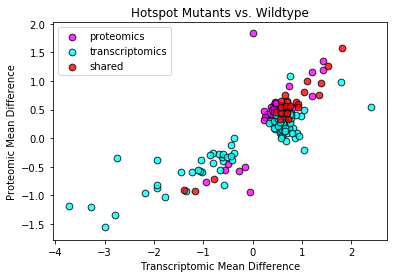

In [30]:
data = get_plot_comp('Hotspot', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=45, label=group)
    
plt.title('Hotspot Mutants vs. Wildtype')
plt.legend(loc=2)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

In [66]:
hotspot_int = all_data.loc[all_data['Hotspot_Sig_In'] == 'Transcriptome']
hotspot_anomaly = hotspot_int.loc[hotspot_int['Hotspot_Prot_Mean_Dif'] >= 0.489798799535328]
hotspot_anomaly

,Protein,All_Txn_pval,All_Txn_pval_-Log10,All_Prot_pval,All_Prot_pval_-Log10,All_Txn_Mean_Dif,All_Prot_Mean_Dif,All_Sig_In,Hotspot_Txn_pval,Hotspot_Txn_pval_-Log10,...,Hotspot_Txn_Mean_Dif,Hotspot_Prot_Mean_Dif,Hotspot_Sig_In,Non_Hotspot_Txn_pval,Non_Hotspot_Txn_pval_-Log10,Non_Hotspot_Prot_pval,Non_Hotspot_Prot_pval_-Log10,Non_Hotspot_Txn_Mean_Dif,Non_Hotspot_Prot_Mean_Dif,Non_Hotspot_Sig_In
738,ATAD3B,5.974833e-07,6.223674,2.252284e-05,4.647377,0.601869,1.237472,Transcriptome,3.151847e-06,5.501435,...,0.759646,1.077900,Transcriptome,3.420582e-04,3.465900,0.000208,3.682047,0.444091,1.397045,Neither
2412,DDX27,4.420738e-11,10.354505,6.655045e-07,6.176849,0.625727,0.420481,Both,2.204332e-08,7.656723,...,0.696108,0.491753,Transcriptome,1.462238e-07,6.834982,0.000431,3.365332,0.561744,0.355689,Transcriptome
3487,FSD1,9.578190e-07,6.018717,4.625082e-02,1.334881,2.117941,0.527293,Transcriptome,1.314913e-06,5.881103,...,2.397706,0.551676,Transcriptome,3.861075e-04,3.413292,0.175491,0.755746,1.718277,0.492460,Neither
4342,IFIT1,2.111574e-06,5.675394,1.461410e-06,5.835228,1.405875,0.888317,Both,2.394766e-06,5.620737,...,1.789351,0.983691,Transcriptome,5.107004e-03,2.291834,0.000582,3.235227,1.057260,0.801614,Neither
5498,MGME1,4.513536e-07,6.345483,3.130806e-06,5.504344,0.570161,0.555266,Both,1.142686e-06,5.942073,...,0.719351,0.547137,Transcriptome,5.765943e-04,3.239130,0.000046,4.333053,0.434533,0.562657,Neither
9398,TBCB,1.704260e-05,4.768464,1.022251e-03,2.990443,0.423874,0.357220,Neither,2.510231e-06,5.600286,...,0.601541,0.547767,Transcriptome,2.460753e-02,1.608932,0.155116,0.809343,0.262359,0.183995,Neither
9816,TOMM70,4.318981e-06,5.364619,6.408999e-05,4.193210,0.513649,0.558397,Transcriptome,2.862300e-06,5.543285,...,0.706649,0.648052,Transcriptome,1.839545e-03,2.735290,0.005489,2.260505,0.338194,0.476893,Neither


In [73]:
hotspot_anomaly['Hotspot_Prot_pval']

738     0.005938
2412    0.000014
3487    0.069556
4342    0.000043
5498    0.000566
9398    0.000176
9816    0.000589
Name: Hotspot_Prot_pval, dtype: float64

In [74]:
hotspot_anomaly['Hotspot_Prot_Mean_Dif']

738     1.077900
2412    0.491753
3487    0.551676
4342    0.983691
5498    0.547137
9398    0.547767
9816    0.648052
Name: Hotspot_Prot_Mean_Dif, dtype: float64

In [71]:
Txn_List = ('ATAD3B', 'DDX27', 'FSD1', 'IFIT1', 'MGME1', 'TBCB', 'TOMM70')
anomaly_df = pd.DataFrame()
for protein in Txn_List:
    anomaly_df[protein] = proteomics[protein]
    
anomaly_df


,ATAD3B,DDX27,FSD1,IFIT1,MGME1,TBCB,TOMM70
S001,-0.04730,0.63700,0.0673,0.6820,2.17000,-0.6840,0.797000
S002,NaN,0.10100,-1.0000,-0.8810,0.30000,0.2240,-0.007170
S003,0.81400,-0.02090,NaN,0.0287,0.03610,-0.3590,0.371000
S005,1.28000,0.20500,NaN,0.9800,0.48000,-0.1810,0.538000
S006,4.07000,0.75500,-0.1420,1.0700,0.70400,0.9260,2.430000
S007,NaN,-0.07040,-1.7300,-0.1630,0.02260,-0.2510,0.475000
S008,NaN,0.20000,-0.5170,-0.6670,0.43500,-0.3500,-0.037500
S009,1.31000,1.11000,0.8710,0.6760,1.15000,1.0900,0.324000
S010,-0.60000,-0.04710,-0.2550,0.1570,-0.50100,-0.6280,0.288000
S011,-1.06000,-0.07960,NaN,-0.3710,-0.32800,-0.2250,-0.128000


### Graphing the same sets of data from each of the different comparison groups

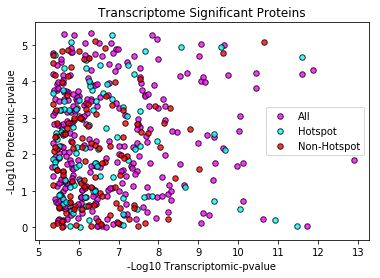

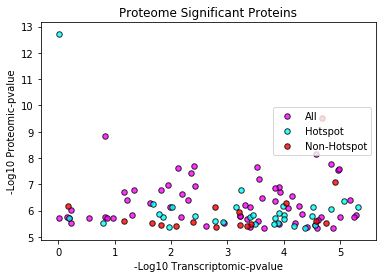

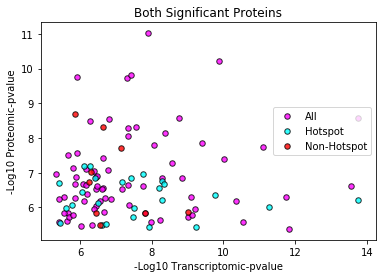

In [26]:
data = get_plot_data('Transcriptome', 'pval_-Log10', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Transcriptome Significant Proteins')
plt.legend(loc=5)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

data = get_plot_data('Proteome', 'pval_-Log10', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Proteome Significant Proteins')
plt.legend(loc=5)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

data = get_plot_data('Both', 'pval_-Log10', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Both Significant Proteins')
plt.legend(loc=5)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

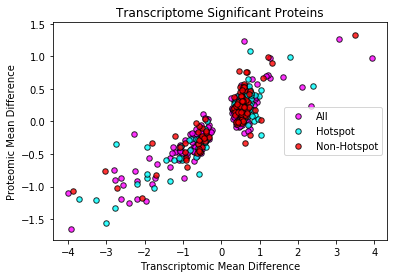

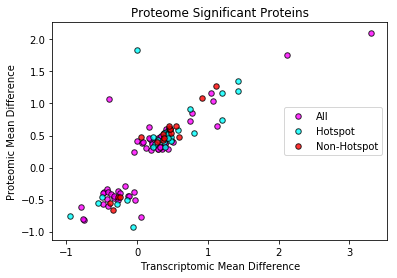

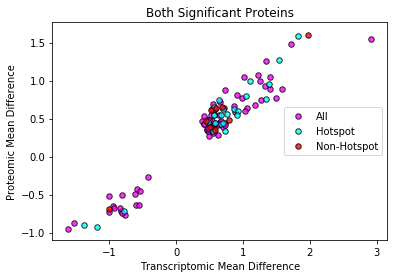

In [27]:
data = get_plot_data('Transcriptome', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Transcriptome Significant Proteins')
plt.legend(loc=5)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

data = get_plot_data('Proteome', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Proteome Significant Proteins')
plt.legend(loc=5)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

data = get_plot_data('Both', 'Mean_Dif', all_data)

colors = ('magenta', 'cyan', 'red')
groups = ('All', 'Hotspot', 'Non-Hotspot')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Both Significant Proteins')
plt.legend(loc=5)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()